In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [48]:
data = pd.read_csv("cardata.csv")
df = pd.DataFrame(data)

In [49]:
df.describe(include="all") # no missing values

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
count,301,301.000000,301.000000,301.000000,301.000000,301,301,301,301.000000
unique,98,NaN,NaN,NaN,NaN,3,2,2,NaN
top,city,NaN,NaN,NaN,NaN,Petrol,Dealer,Manual,NaN
freq,26,NaN,NaN,NaN,NaN,239,195,261,NaN
mean,NaN,2013.627907,4.661296,7.628472,36947.205980,NaN,NaN,NaN,0.043189
std,NaN,2.891554,5.082812,8.644115,38886.883882,NaN,NaN,NaN,0.247915
min,NaN,2003.000000,0.100000,0.320000,500.000000,NaN,NaN,NaN,0.000000
25%,NaN,2012.000000,0.900000,1.200000,15000.000000,NaN,NaN,NaN,0.000000
50%,NaN,2014.000000,3.600000,6.400000,32000.000000,NaN,NaN,NaN,0.000000
75%,NaN,2016.000000,6.000000,9.900000,48767.000000,NaN,NaN,NaN,0.000000


In [50]:
# we can drop Car_Name
df = df.drop(columns="Car_Name")

In [51]:
# let's change Year to Age based on MAX of Year+1
df.insert(1,"Age",df["Year"].max()+1-df["Year"])

In [52]:
df.drop(columns="Year",inplace=True)

In [53]:
df[df["Fuel_Type"]=="CNG"]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
18,4,3.25,5.09,35500,CNG,Dealer,Manual,0
35,8,2.95,7.74,49998,CNG,Dealer,Manual,0


In [54]:
dfnu =  df.copy()
dfnu.sample(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
21,2,4.90,5.710,2400,Petrol,Dealer,Manual,0
146,5,0.55,0.787,15000,Petrol,Individual,Manual,0
101,2,1.70,1.820,1400,Petrol,Individual,Manual,0
173,2,0.40,0.510,1300,Petrol,Individual,Automatic,0
64,2,33.00,36.230,6000,Diesel,Dealer,Automatic,0


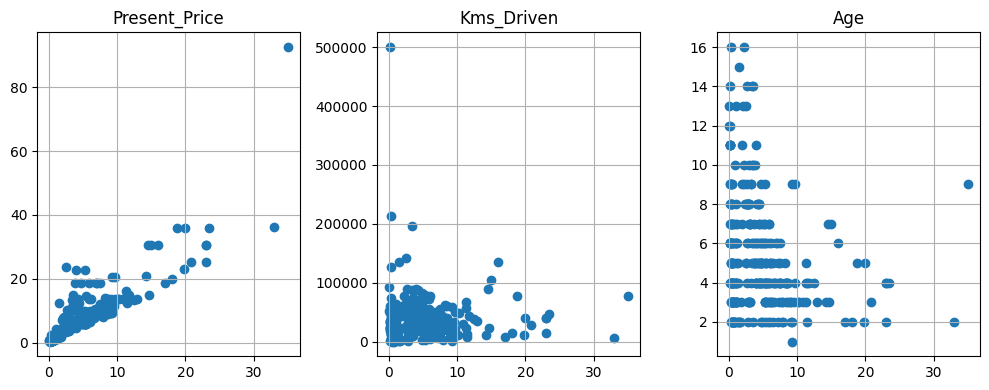

In [55]:
fig, axs = plt.subplots(1,3,sharex=False, figsize=(10, 4))
axs[0].scatter(dfnu["Selling_Price"],dfnu["Present_Price"])
axs[0].grid();axs[0].set_title("Present_Price")
axs[1].scatter(dfnu["Selling_Price"],dfnu["Kms_Driven"])
axs[1].grid();axs[1].set_title("Kms_Driven")
axs[2].scatter(dfnu["Selling_Price"],dfnu["Age"])
axs[2].grid();axs[2].set_title("Age")
fig.tight_layout()

In [56]:
# let's remove all Selling price more than 30 and Kms driven more than 400k, 
# because these three records are remote and may affect our model.
# so let's remove them for now and make our model
dfnu[(dfnu["Selling_Price"]>30) | (dfnu["Kms_Driven"]>400000)]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
64,2,33.00,36.23,6000,Diesel,Dealer,Automatic,0
86,9,35.00,92.60,78000,Diesel,Dealer,Manual,0
196,11,0.17,0.52,500000,Petrol,Individual,Automatic,0


In [57]:
dfnu = dfnu.drop([64,86,196]).reset_index().drop(columns="index")

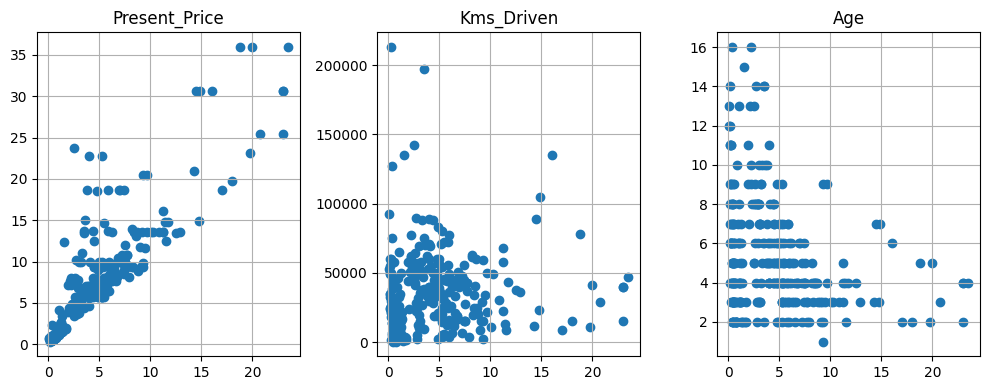

In [58]:
fig, axs = plt.subplots(1,3,sharex=False, figsize=(10, 4))
axs[0].scatter(dfnu["Selling_Price"],dfnu["Present_Price"])
axs[0].grid();axs[0].set_title("Present_Price")
axs[1].scatter(dfnu["Selling_Price"],dfnu["Kms_Driven"])
axs[1].grid();axs[1].set_title("Kms_Driven")
axs[2].scatter(dfnu["Selling_Price"],dfnu["Age"])
axs[2].grid();axs[2].set_title("Age")
fig.tight_layout()

In [59]:
# converting catergories to numbers
dfnu["Fuel_Type"] = dfnu["Fuel_Type"].replace(["CNG","Petrol","Diesel"], [4.0,3.0,2.0])
dfnu["Seller_Type"] = dfnu["Seller_Type"].replace(["Dealer","Individual"], [3.0,2.0])
dfnu["Transmission"] = dfnu["Transmission"].replace(["Automatic","Manual"], [3.0,2.0])
dfnu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            298 non-null    int64  
 1   Selling_Price  298 non-null    float64
 2   Present_Price  298 non-null    float64
 3   Kms_Driven     298 non-null    int64  
 4   Fuel_Type      298 non-null    float64
 5   Seller_Type    298 non-null    float64
 6   Transmission   298 non-null    float64
 7   Owner          298 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 18.8 KB


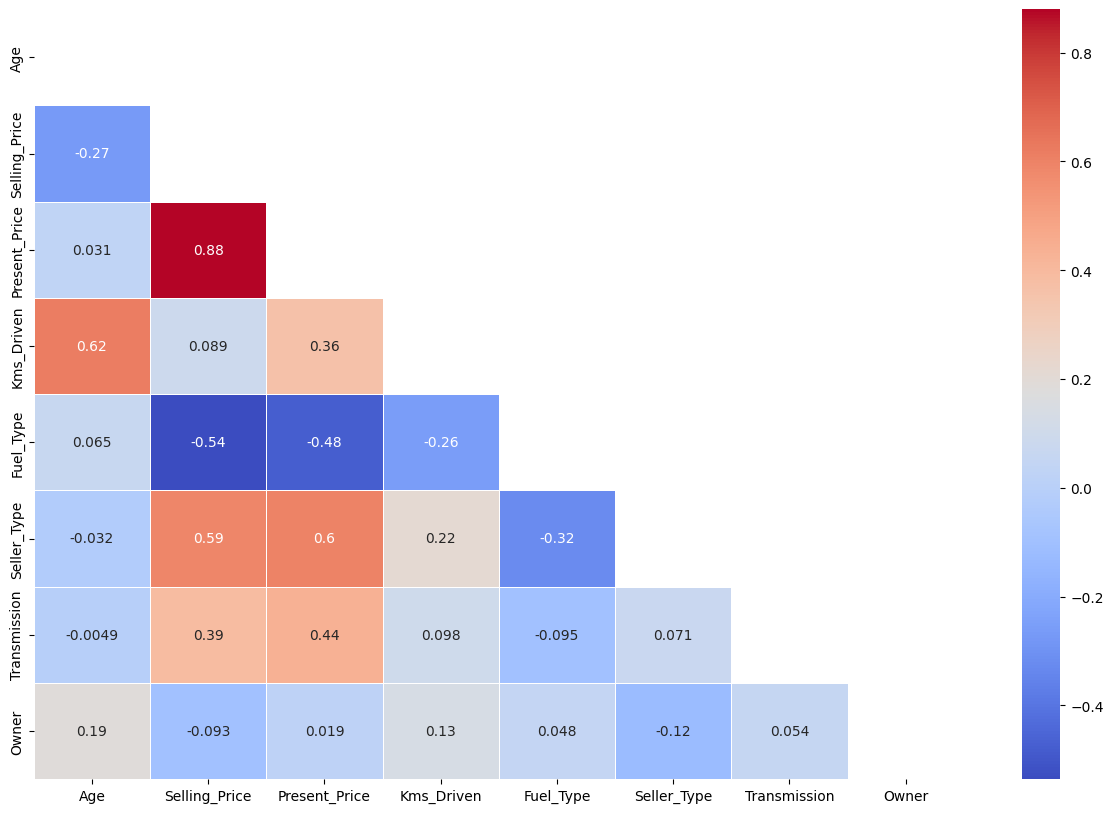

In [60]:
plt.figure(figsize=(15,10))
sns.heatmap(dfnu.corr(), annot=True,linewidth=.5,cmap="coolwarm",mask=np.triu(dfnu.corr()));

In [61]:
len(dfnu)

298

In [62]:
kfv = KFold(5)
ts = 0.2
resultcv = pd.DataFrame()

#### x1 = Age
#### x2 = Present_Price
#### x3 = Kms_Driven
#### x4 = Fuel_Type
#### x5 = Seller_Type
#### x6 = Transmission
#### x7 = Owner

# Model1 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)

In [63]:
#model creation
dfn1 = dfnu.copy()

#normalizing
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
N1 = scaler.fit_transform(dfn1.drop(columns=["Selling_Price"]))
dfw1 = pd.DataFrame(N1,columns = list(dfn1.drop(columns=["Selling_Price"]).columns))
dfw1["Selling_Price"] = dfn1["Selling_Price"]

#x and y define
x1=dfw1.drop(columns=["Selling_Price"])
y1=dfw1["Selling_Price"].values.reshape(-1,1)
x_train1, x_test1, y_train1, y_test1=train_test_split(x1,y1, test_size=ts,random_state=0)

regressor = LinearRegression()

#KFold Test
results = cross_val_score(regressor,x1,y1,cv=kfv)
regressor.fit(x_train1,y_train1)
resultcv.insert(0,"M1",np.append(results,[(np.mean(results)),regressor.score(x1,y1),regressor.score(x_test1,y_test1)]))

# Model2 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x2^2)

In [64]:
#model creation
dfn2 = dfnu.copy()
dfn2["Kms/Age"] = dfn2["Kms_Driven"]/dfn2["Age"]
dfn2["Present_Price^2"] = dfn2["Present_Price"].astype("float64")**(2)

#normalizing
N2 = scaler.fit_transform(dfn2.drop(columns=["Selling_Price"]))
dfw2 = pd.DataFrame(N2,columns = list(dfn2.drop(columns=["Selling_Price"]).columns))
dfw2["Selling_Price"] = dfn2["Selling_Price"]

#x and y define
x2=dfw2.drop(columns=["Selling_Price"])
y2=dfw2["Selling_Price"].values.reshape(-1,1)
x_train2, x_test2, y_train2, y_test2=train_test_split(x2,y2, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x2,y2,cv=kfv)
regressor.fit(x_train2,y_train2)
resultcv.insert(0,"M2[(x4)/(x1)+(x2^2)]",np.append(results,[(np.mean(results)),regressor.score(x2,y2),regressor.score(x_test2,y_test2)]))
#end

# Model3 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x2^3)

In [65]:
#model creation
dfn3 = dfnu.copy()
dfn3["Kms/Age"] = dfn3["Kms_Driven"]/dfn3["Age"]
dfn3["Present_Price^3"] = dfn3["Present_Price"].astype("float64")**(3)

#normalizing
N3 = scaler.fit_transform(dfn3.drop(columns=["Selling_Price"]))
dfw3 = pd.DataFrame(N3,columns = list(dfn3.drop(columns=["Selling_Price"]).columns))
dfw3["Selling_Price"] = dfn3["Selling_Price"]

#x and y define
x3=dfw3.drop(columns=["Selling_Price"])
y3=dfw3["Selling_Price"].values.reshape(-1,1)
x_train3, x_test3, y_train3, y_test3=train_test_split(x3,y3, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x3,y3,cv=kfv)
regressor.fit(x_train3,y_train3)
resultcv.insert(0,"M3[(x4)/(x1)+(x2^3)]",np.append(results,[(np.mean(results)),regressor.score(x3,y3),regressor.score(x_test3,y_test3)]))
#end

# Model4 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)

In [66]:
#model creation
dfn4 = dfnu.copy()
dfn4["Kms/Age"] = dfn4["Kms_Driven"]/dfn4["Age"]
dfn4["Fue*Sel*Tran"] = dfn4["Fuel_Type"]*dfn4["Seller_Type"]*dfn4["Transmission"]

#normalizing
N4 = scaler.fit_transform(dfn4.drop(columns=["Selling_Price"]))
dfw4 = pd.DataFrame(N4,columns = list(dfn4.drop(columns=["Selling_Price"]).columns))
dfw4["Selling_Price"] = dfn4["Selling_Price"]

#x and y define
x4=dfw4.drop(columns=["Selling_Price"])
y4=dfw4["Selling_Price"].values.reshape(-1,1)
x_train4, x_test4, y_train4, y_test4=train_test_split(x4,y4, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x4,y4,cv=kfv)
regressor.fit(x_train4,y_train4)
resultcv.insert(0,"M4[(x4)/(x1)+(x4)(x5)(x6)]",np.append(results,[(np.mean(results)),regressor.score(x4,y4),regressor.score(x_test4,y_test4)]))
#end

# Model5 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)+J(x2)(x6)

In [67]:
#model creation
dfn5 = dfn4.copy()
dfn5["Pres*Trans"] = dfn5["Present_Price"]*dfn5["Transmission"]

#normalizing
N5 = scaler.fit_transform(dfn5.drop(columns=["Selling_Price"]))
dfw5 = pd.DataFrame(N5,columns = list(dfn5.drop(columns=["Selling_Price"]).columns))
dfw5["Selling_Price"] = dfn5["Selling_Price"]

#x and y define
x5=dfw5.drop(columns=["Selling_Price"])
y5=dfw5["Selling_Price"].values.reshape(-1,1)
x_train5, x_test5, y_train5, y_test5=train_test_split(x5,y5, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x5,y5,cv=kfv)
regressor.fit(x_train5,y_train5)
resultcv.insert(0,"M5[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)]",np.append(results,[(np.mean(results)),regressor.score(x5,y5),regressor.score(x_test5,y_test5)]))
#end

# Model6 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x2)(x6)

In [68]:
#model creation
dfn6 = dfnu.copy()
dfn6["Kms/Age"] = dfn6["Kms_Driven"]/dfn6["Age"]
dfn6["Pres*Trans"] = dfn6["Present_Price"]*dfn6["Transmission"]

#normalizing
N6 = scaler.fit_transform(dfn6.drop(columns=["Selling_Price"]))
dfw6 = pd.DataFrame(N6,columns = list(dfn6.drop(columns=["Selling_Price"]).columns))
dfw6["Selling_Price"] = dfn6["Selling_Price"]

#x and y define
x6=dfw6.drop(columns=["Selling_Price"])
y6=dfw6["Selling_Price"].values.reshape(-1,1)
x_train6, x_test6, y_train6, y_test6=train_test_split(x6,y6, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x6,y6,cv=kfv)
regressor.fit(x_train6,y_train6)
resultcv.insert(0,"M6[(x4)/(x1)+(x2)(x6)]",np.append(results,[(np.mean(results)),regressor.score(x6,y6),regressor.score(x_test6,y_test6)]))
#end

# Model7 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)+J(x2)(x6)+K(x4)(x6)

In [69]:
#model creation
dfn7 = dfn5.copy()
dfn7["Fue*Trans"] = dfn7["Fuel_Type"]*dfn7["Transmission"]

#normalizing
N7 = scaler.fit_transform(dfn7.drop(columns=["Selling_Price"]))
dfw7 = pd.DataFrame(N7,columns = list(dfn7.drop(columns=["Selling_Price"]).columns))
dfw7["Selling_Price"] = dfn7["Selling_Price"]

#x and y define
x7=dfw7.drop(columns=["Selling_Price"])
y7=dfw7["Selling_Price"].values.reshape(-1,1)
x_train7, x_test7, y_train7, y_test7=train_test_split(x7,y7, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x7,y7,cv=kfv)
regressor.fit(x_train7,y_train7)
resultcv.insert(0,"M7[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)]",np.append(results,[(np.mean(results)),regressor.score(x7,y7),regressor.score(x_test7,y_test7)]))
#end

# Model8 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)+J(x2)(x6)+K(x4)(x6)+M(x1)(x2)

In [70]:
#model creation
dfn8 = dfn7.copy()
dfn8["Age*Pres"] = dfn8["Age"]*dfn8["Present_Price"]

#normalizing
N8 = scaler.fit_transform(dfn8.drop(columns=["Selling_Price"]))
dfw8 = pd.DataFrame(N8,columns = list(dfn8.drop(columns=["Selling_Price"]).columns))
dfw8["Selling_Price"] = dfn8["Selling_Price"]

#x and y define
x8=dfw8.drop(columns=["Selling_Price"])
y8=dfw8["Selling_Price"].values.reshape(-1,1)
x_train8, x_test8, y_train8, y_test8=train_test_split(x8,y8, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x8,y8,cv=kfv)
regressor.fit(x_train8,y_train8)
resultcv.insert(0,"M8[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)+(x1)(x2)]",np.append(results,[(np.mean(results)),regressor.score(x8,y8),regressor.score(x_test8,y_test8)]))
#end

# Model9 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)+J(x4)(x6)+K(x1)(x2)

In [71]:
#model creation
dfn9 = dfn8.drop(columns="Pres*Trans")

#normalizing
N9 = scaler.fit_transform(dfn9.drop(columns=["Selling_Price"]))
dfw9 = pd.DataFrame(N9,columns = list(dfn9.drop(columns=["Selling_Price"]).columns))
dfw9["Selling_Price"] = dfn9["Selling_Price"]

#x and y define
x9=dfw9.drop(columns=["Selling_Price"])
y9=dfw9["Selling_Price"].values.reshape(-1,1)
x_train9, x_test9, y_train9, y_test9=train_test_split(x9,y9, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x9,y9,cv=kfv)
regressor.fit(x_train9,y_train9)
resultcv.insert(0,"M9[(x4)/(x1)+(x4)(x5)(x6)+(x4)(x6)+(x1)(x2)]",np.append(results,[(np.mean(results)),regressor.score(x9,y9),regressor.score(x_test9,y_test9)]))
#end

# Model10 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)+J(x4)(x6)+K(x1)(x2)+L(x2^2)+M(x2^3)

In [72]:
#model creation
dfn10 = dfn9.copy()
dfn10["Present_Price^2"] = dfn10["Present_Price"].astype("float64")**(2)
dfn10["Present_Price^3"] = dfn10["Present_Price"].astype("float64")**(3)

#normalizing
N10 = scaler.fit_transform(dfn10.drop(columns=["Selling_Price"]))
dfw10 = pd.DataFrame(N10,columns = list(dfn10.drop(columns=["Selling_Price"]).columns))
dfw10["Selling_Price"] = dfn10["Selling_Price"]

#x and y define
x10=dfw10.drop(columns=["Selling_Price"])
y10=dfw10["Selling_Price"].values.reshape(-1,1)
x_train10, x_test10, y_train10, y_test10=train_test_split(x10,y10, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x10,y10,cv=kfv)
regressor.fit(x_train10,y_train10)
resultcv.insert(0,"M10[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)+(x2^2)+(x2^3)]",np.append(results,[(np.mean(results)),regressor.score(x10,y10),regressor.score(x_test10,y_test10)]))
#end

# Model11 = A(x1)+B(x2)+C(x3)+D(x4)+E(x5)+F(x6)+G(x7)+H(x4)/(x1)+I(x4)(x5)(x6)+J(x4)(x6)+K(x1)(x2)+L(x2^2)+M(x2^3)+O(x2^4)

In [73]:
#model creation
dfn11 = dfn10.copy()
dfn11["Present_Price^4"] = dfn11["Present_Price"].astype("float64")**(4)

#normalizing
N11 = scaler.fit_transform(dfn11.drop(columns=["Selling_Price"]))
dfw11 = pd.DataFrame(N11,columns = list(dfn11.drop(columns=["Selling_Price"]).columns))
dfw11["Selling_Price"] = dfn11["Selling_Price"]

#x and y define
x11=dfw11.drop(columns=["Selling_Price"])
y11=dfw11["Selling_Price"].values.reshape(-1,1)
x_train11, x_test11, y_train11, y_test11=train_test_split(x11,y11, test_size=ts,random_state=0)

#KFold Test
results = cross_val_score(regressor,x11,y11,cv=kfv)
regressor.fit(x_train11,y_train11)
resultcv.insert(0,"M11[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)+(x2^2)+(x2^3)+(x2^4)]",np.append(results,[(np.mean(results)),regressor.score(x11,y11),regressor.score(x_test11,y_test11)]))
#end

In [74]:
for i in resultcv.index:
    resultcv.rename(index = {i: "Kfold{}".format(i+1)},inplace = True)
resultcv.rename(index = {"Kfold{}".format(i-1):"Average"} ,inplace = True)
resultcv.rename(index = {"Kfold{}".format(i):"Score(x,y)"} ,inplace = True)
resultcv.rename(index = {"Kfold{}".format(i+1):"Score(x_test,y_test)"} ,inplace = True)

In [75]:
resultcv.iloc[:,:].T

,Kfold1,Kfold2,Kfold3,Kfold4,Kfold5,Average,"Score(x,y)","Score(x_test,y_test)"
M11[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)+(x2^2)+(x2^3)+(x2^4)],0.955830,0.949985,-3.975534,0.936517,0.923977,-0.041845,0.966504,0.975137
M10[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)+(x2^2)+(x2^3)],0.954355,0.947864,-1.649118,0.932226,0.919496,0.420965,0.965891,0.973872
M9[(x4)/(x1)+(x4)(x5)(x6)+(x4)(x6)+(x1)(x2)],0.948367,0.945038,-1.103212,0.922344,0.930014,0.528510,0.963208,0.975851
M8[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)+(x1)(x2)],0.949598,0.941477,-1.877015,0.913277,0.927325,0.370932,0.963454,0.976704
M7[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)+(x4)(x6)],0.914140,0.853397,-59.383603,0.812757,0.835429,-11.193576,0.908082,0.951183
M6[(x4)/(x1)+(x2)(x6)],0.895149,0.810652,-73.368866,0.764904,0.853345,-14.008963,0.895011,0.936451
M5[(x4)/(x1)+(x4)(x5)(x6)+(x2)(x6)],0.896730,0.807706,-93.524453,0.761121,0.837717,-18.044236,0.895131,0.932535
M4[(x4)/(x1)+(x4)(x5)(x6)],0.893121,0.804661,-99.211380,0.764618,0.863319,-19.177132,0.893136,0.930974
M3[(x4)/(x1)+(x2^3)],0.892432,0.797153,-78.900998,0.772123,0.867705,-15.114317,0.892944,0.933691
M2[(x4)/(x1)+(x2^2)],0.892183,0.799042,-79.021240,0.772136,0.866353,-15.138305,0.892959,0.933849


In [76]:
regressor = LinearRegression()
regressor.fit(x_train8,y_train8)
y_pred8 = regressor.predict(x_test8)
nx_test8 = x_test8.copy()
nx_test8["Y_Test"] = y_test8
nx_test8["Y_Prediction"] = y_pred8

In [77]:
print("MAE", metrics.mean_absolute_error(y_test8,y_pred8))
print("MSE", metrics.mean_squared_error(y_test8,y_pred8))
print("RMAE", np.sqrt(metrics.mean_absolute_error(y_test8,y_pred8)))
print("R2S", metrics.r2_score(y_test8,y_pred8))

MAE 0.5390093181805682
MSE 0.5287110818358093
RMAE 0.7341725397892298
R2S 0.9767036499189252


In [78]:
# Train and Test datafarme ( Red dots are Test records ) (note that feaures are scaled that's why they are between 0-1 )
# X axis is selling price

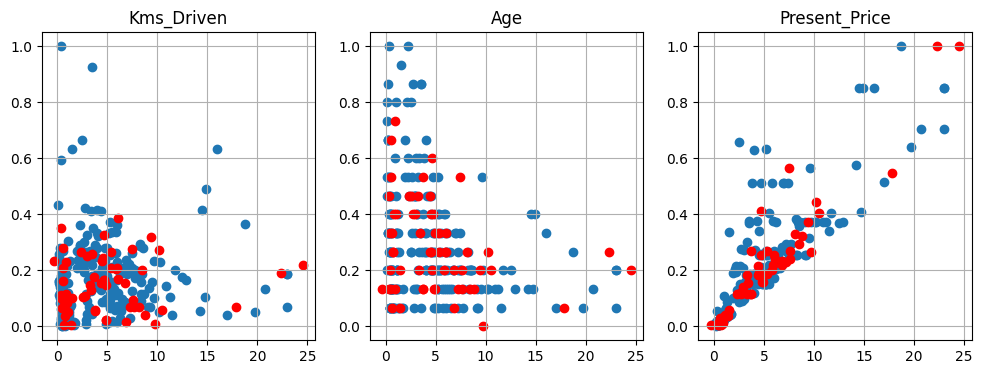

In [79]:
fig, axs = plt.subplots(1,3,sharex=False, figsize=(12, 4))
axs[1].scatter(y_train8,x_train8["Age"])
axs[1].scatter(y_pred8,x_test8["Age"],color="Red")
axs[1].grid();axs[1].set_title("Age")
axs[2].scatter(y_train8,x_train8["Present_Price"])
axs[2].scatter(y_pred8,x_test8["Present_Price"],color="Red")
axs[2].grid();axs[2].set_title("Present_Price")
axs[0].scatter(y_train8,x_train8["Kms_Driven"])
axs[0].scatter(y_pred8,x_test8["Kms_Driven"],color="Red")
axs[0].grid();axs[0].set_title("Kms_Driven");

In [80]:
# Regression Line in Test dataframe (Y axis is selling prices)

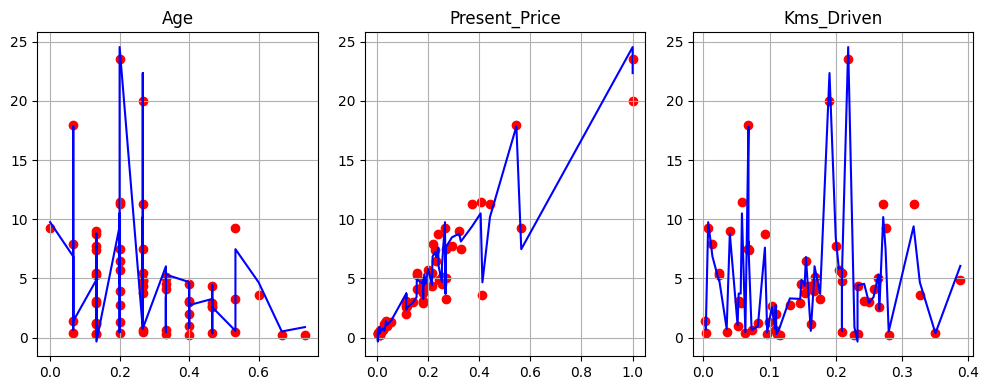

In [81]:
fig, axs = plt.subplots(1,3,sharex=False, figsize=(10, 4))
axs[0].plot(nx_test8.sort_values(by="Age")["Age"],nx_test8.sort_values(by="Age")["Y_Prediction"],color="Blue")
axs[0].scatter(nx_test8.sort_values(by="Age")["Age"],nx_test8.sort_values(by="Age")["Y_Test"],color="Red")
axs[0].grid();axs[0].set_title("Age")
axs[1].plot(nx_test8.sort_values(by="Present_Price")["Present_Price"],nx_test8.sort_values(by="Present_Price")["Y_Prediction"],color="Blue")
axs[1].scatter(nx_test8.sort_values(by="Present_Price")["Present_Price"],nx_test8.sort_values(by="Present_Price")["Y_Test"],color="Red")
axs[1].grid();axs[1].set_title("Present_Price")
axs[2].plot(nx_test8.sort_values(by="Kms_Driven")["Kms_Driven"],nx_test8.sort_values(by="Kms_Driven")["Y_Prediction"],color="Blue")
axs[2].scatter(nx_test8.sort_values(by="Kms_Driven")["Kms_Driven"],nx_test8.sort_values(by="Kms_Driven")["Y_Test"],color="Red")
axs[2].grid();axs[2].set_title("Kms_Driven");
fig.tight_layout()

In [82]:
# Comparing Y_test and Y_pred

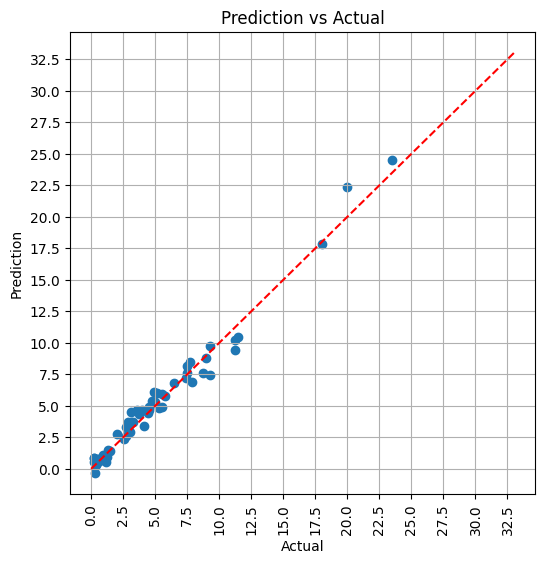

In [83]:
plt.figure(figsize=(6,6));plt.scatter(y_test8,y_pred8);plt.title("Prediction vs Actual");
plt.xticks(np.arange(0,33,2.5),rotation=90);plt.yticks(np.arange(0,33,2.5));plt.xlabel("Actual");plt.ylabel("Prediction");plt.grid();
plt.plot([0, 33], [0, 33], ls="--", c="Red");

In [84]:
# Input dataframe

In [85]:
dfn8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            298 non-null    int64  
 1   Selling_Price  298 non-null    float64
 2   Present_Price  298 non-null    float64
 3   Kms_Driven     298 non-null    int64  
 4   Fuel_Type      298 non-null    float64
 5   Seller_Type    298 non-null    float64
 6   Transmission   298 non-null    float64
 7   Owner          298 non-null    int64  
 8   Kms/Age        298 non-null    float64
 9   Fue*Sel*Tran   298 non-null    float64
 10  Pres*Trans     298 non-null    float64
 11  Fue*Trans      298 non-null    float64
 12  Age*Pres       298 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 30.4 KB


In [87]:
nd = {"Age":[8,5,1,13,6,2,12,10,10],"Present_Price":[8.75,10.35,17.85,25.25,13.14,10,24.24,18.85,11.23],
        "Kms_Driven":[7000,10000,13000,25000,20000,20000,20000,85000,42000],
        "Fuel_Type":[3.0,2.0,3.0,2.0,3.0,3.0,3.0,2.0,4.0],"Seller_Type":[2.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0],
        "Transmission":[3.0,2.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0],"Owner":[2,3,2,4,3,1,3,2,2]}
df_t = pd.DataFrame(nd)
df_t["Kms/Age"] = df_t["Kms_Driven"]/df_t["Age"]
df_t["Fue*Sel*Tran"] = df_t["Fuel_Type"]*df_t["Seller_Type"]*df_t["Transmission"]
df_t["Pres*Trans"] = df_t["Present_Price"]*df_t["Transmission"]
df_t["Fue*Trans"] = df_t["Fuel_Type"]*df_t["Transmission"]
df_t["Age*Pres"] = df_t["Age"]*df_t["Present_Price"]
df_test = dfn8.drop(columns="Selling_Price")._append(df_t)

In [88]:
Nt = scaler.fit_transform(df_test)
df_testw = pd.DataFrame(Nt,columns = list(dfn8.drop(columns="Selling_Price")))
df_testw.head()

,Age,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Kms/Age,Fue*Sel*Tran,Pres*Trans,Fue*Trans,Age*Pres
0,0.266667,0.147868,0.124706,0.5,1.0,0.0,0.0,0.222695,0.526316,0.098284,0.4,0.082297
1,0.333333,0.258698,0.200000,0.0,1.0,0.0,0.0,0.297872,0.210526,0.171951,0.0,0.171806
2,0.066667,0.267396,0.030118,0.5,1.0,0.0,0.0,0.139716,0.526316,0.177732,0.4,0.057085
3,0.466667,0.107464,0.022118,0.5,1.0,0.0,0.0,0.020567,0.526316,0.071429,0.4,0.098341
4,0.266667,0.183782,0.197412,0.0,1.0,0.0,0.0,0.354184,0.210526,0.122156,0.0,0.101855


In [91]:
xt = df_testw.iloc[:len(dfn8),:]
yt = dfw8["Selling_Price"].values.reshape(-1,1)
regressor.fit(xt,yt)
y_predt = regressor.predict(df_testw.iloc[len(dfn8):,:])
dfx = df_test.iloc[:len(dfn8),:].copy();dfx["Selling_Price"]=dfn8["Selling_Price"]
dfp = df_test.iloc[len(dfn8):,:].copy();dfp["Selling_Price"]=y_predt
df_tf = dfx._append(dfp)
df_tf.head()

,Age,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Kms/Age,Fue*Sel*Tran,Pres*Trans,Fue*Trans,Age*Pres,Selling_Price
0,5,5.59,27000,3.0,3.0,2.0,0,5400.000000,18.0,11.18,6.0,27.95,3.35
1,6,9.54,43000,2.0,3.0,2.0,0,7166.666667,12.0,19.08,4.0,57.24,4.75
2,2,9.85,6900,3.0,3.0,2.0,0,3450.000000,18.0,19.70,6.0,19.70,7.25
3,8,4.15,5200,3.0,3.0,2.0,0,650.000000,18.0,8.30,6.0,33.20,2.85
4,5,6.87,42450,2.0,3.0,2.0,0,8490.000000,12.0,13.74,4.0,34.35,4.60


In [92]:
# Red dots are predicted Selling Prices

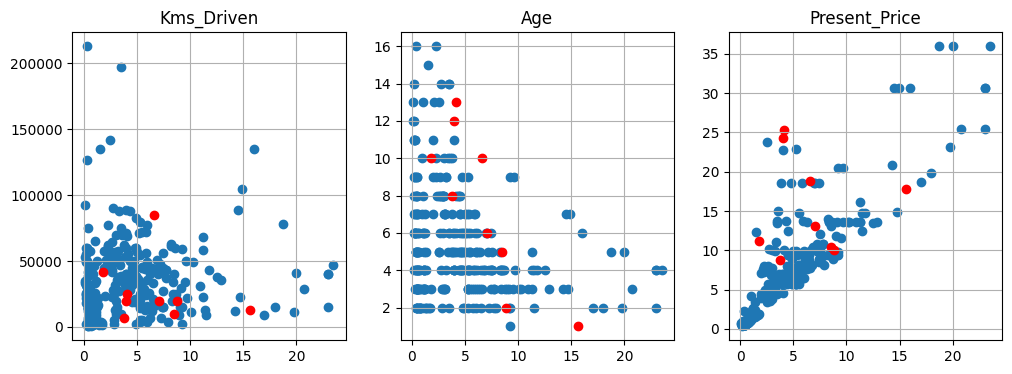

In [93]:
fig, axs = plt.subplots(1,3,sharex=False, figsize=(12, 4))
axs[1].scatter(dfx["Selling_Price"],dfx["Age"])
axs[1].scatter(dfp["Selling_Price"],dfp["Age"],color="Red")
axs[1].grid();axs[1].set_title("Age")
axs[2].scatter(dfx["Selling_Price"],dfx["Present_Price"])
axs[2].scatter(dfp["Selling_Price"],dfp["Present_Price"],color="Red")
axs[2].grid();axs[2].set_title("Present_Price")
axs[0].scatter(dfx["Selling_Price"],dfx["Kms_Driven"])
axs[0].scatter(dfp["Selling_Price"],dfp["Kms_Driven"],color="Red")
axs[0].grid();axs[0].set_title("Kms_Driven");